# Text Analytics: Sentiment Analysis of Products Review on Amazon

## Table of Contents

* [Libraries](#section1)
* [Dataset](#section1)

# Libraries <a class="anchor" id="section1"></a>

In [2]:
# DataFrame
import pandas as pd 

# plotting
import seaborn as sns
import sys
import wordcloud # pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
import nltk
# from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')

import re

# sklearn
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV #, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier

# scipy
from scipy import interp

# imblearn
from imblearn.over_sampling import SMOTE # conda install -c conda-forge imbalanced-learn
# from imblearn.combine import SMOTETomek # pip install -U imbalanced-learn
from imblearn.pipeline import make_pipeline, Pipeline
# from imblearn.under_sampling import NearMiss

# Utility
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle
from collections import Counter
from itertools import cycle
import itertools

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Dataset <a class="anchor" id="section2"></a>
[About dataset](https://www.kaggle.com/datasets/nehaprabhavalkar/indian-products-on-amazon)

In [3]:
data = pd.read_csv('../input/indian-products-on-amazon/amazon_vfl_reviews.csv' ,encoding='latin', names = ['asian','name','date','rating','text'], skiprows=1) # encoding="UTF-8". skiprows=1: Skips the first row from top in the csv file
data.head(3)

,asian,name,date,rating,text
0,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-09-06,1,I bought this hair oil after viewing so many g...
1,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-08-14,5,Used This Mama Earth Newly Launched Onion Oil ...
2,B07W7CTLD1,Mamaearth-Onion-Growth-Control-Redensyl,2019-10-19,1,So bad product...My hair falling increase too ...


# Data size

In [4]:
reviewColName = 'text' # Better programming practice: The name of review column is stored in a variable, so that in other dataset with different column name it is only enough to change this variable
ratingColName = 'rating' # Better programming practice:
ratingOrigColName = ratingColName +'Orig'
data[ratingOrigColName] = data[ratingColName] # Store the original ratings, then merge/group the ratings
random_state = 0
print('Rows nb: {}\nColumns nb: {}\nColumn names: {}'.format(data.shape[0], data.shape[1], (', ').join(list(data.columns)))) # Displays the size of the data

Rows nb: 2782
Columns nb: 6
Column names: asian, name, date, rating, text, ratingOrig


In [20]:
# frac = 1; # For 'frac=1', no sampling is done and it just randomises the order of the rows (the 'sort_index()' method can recover the original rows order).
# data1 = data.sample(frac=frac) 
# data1.head(10)

# Data wrangling:
* Removing rows containing NA/NAN values;
* Removes non-word text tokens (HTML markup, emoticons, ...);
* Stem of text tokens;
* Removing stop-words text tokens.

4 rows containing NA/NAN were removed.


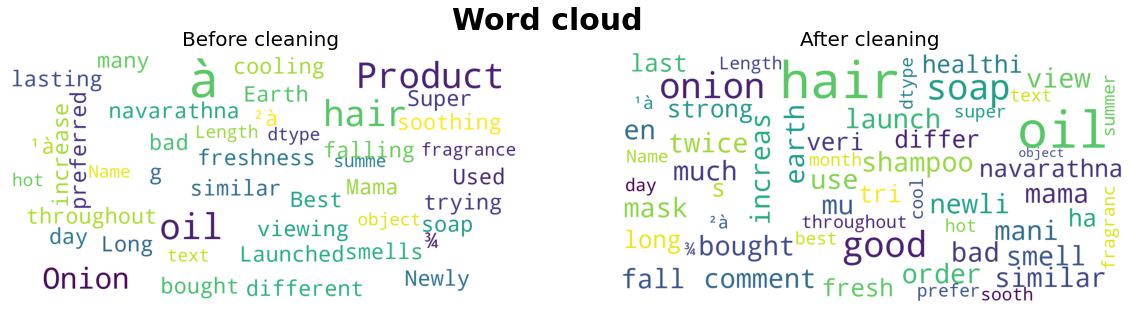

In [5]:
def na_remover(dfIn):
    """Removes rows containing NA/NAN values"""
    dfOut = dfIn.dropna()
    print("{} rows containing NA/NAN were removed.".format(dfIn.shape[0] - dfOut.shape[0]))
    return dfOut


def nonWord_remover(textIn):
    """Removes non-word text tokens"""
    textOut = re.sub('<[^>]*>', '', textIn) # Removes all of the HTML markup from the reviews.
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', textOut) # Finds emoticons
    textOut = (re.sub('[\W]+', ' ', textOut.lower()) + ' '.join(emoticons).replace('-', '')) # Removes all non-word characters from the text via the regex [\W]+ and converts the text into lowercase characters.
    return textOut


porter = PorterStemmer()
def word_stemmer(textIn):
    """Stem of text tokens"""
    textOut = [porter.stem(word) for word in textIn.split()]
    return textOut


stopWords = stopwords.words('english')+['product', 'thi', 'à', 'the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
def stopWords_remover(textIn):
    """Removes stop-words text tokens"""
    textOut = ' '.join([word for word in textIn if word not in stopWords])
    return textOut


def mostCommonWords_finder(df, N, lenMin):
    """Finds the most common N words of minimum length of lenMin"""
    all_words = []
    for line in list(df):
        words = line.split()
        for word in words:
          if (len(word) > lenMin):
            all_words.append(word.lower()) 
    return Counter(all_words).most_common(N)


def wrangler(dfIn, textColumn):
    """Removes NA/NAN values & non-word & stop-words text tokens"""
    dfOut = na_remover(dfIn) # Removes rows containing NA/NAN values
    dfOut[textColumn] = dfOut[textColumn].apply(nonWord_remover) # Removes non-word text tokens
    dfOut[textColumn] = dfOut[textColumn].apply(word_stemmer) # Stem of text tokens
    dfOut[textColumn] = dfOut[textColumn].apply(stopWords_remover) # Removes stop-words text tokens
    return dfOut


def wordcloud_plotter(ax, data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
    ax.axis('off')
    if title: 
        ax.set_title(title, fontsize = 20)
    ax.imshow(wordcloud)


def classSize_plotter(df, df_col, title):
    sns.countplot(x = df_col, hue=df_col, data = df, dodge=False)
    plt.suptitle(title, fontweight='bold')
    plt.savefig("../working/{}.png".format(title))
    
    
dataCleaned = wrangler(data, reviewColName)

# Word cloud
fig, axs = plt.subplots(1, 2, figsize = (20, 5)) 
fig.suptitle('Word cloud', fontsize= 30, fontweight='bold')
wordcloud_plotter(axs[0], data[reviewColName], 'Before cleaning')
wordcloud_plotter(axs[1], dataCleaned[reviewColName], 'After cleaning')
plt.savefig("../working/wordCloud.png")

# Imbalanced (skewed) class size

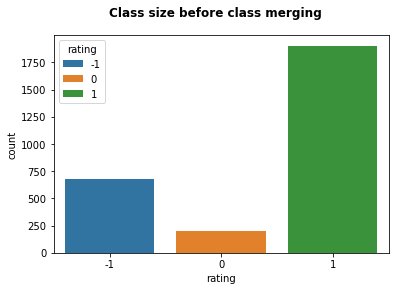

In [14]:
# %matplotlib inline

    
classSize_plotter(dataCleaned, ratingColName, 'Class size before class merging')

In [6]:
n_splits = 3 #4 Fold number in K-fold CV
clfParamName = 'clf' # common word used in param_grid & Pipeline
clfNames = ['knn', 'lr']

smoteClassSize = dataCleaned[ratingColName].value_counts().iloc[0]
sampling_strategy = {1:1500, 2:1500,3:1500,4:1500,5:1500}
smote = SMOTE(random_state=random_state, sampling_strategy=sampling_strategy ) #  , k_neighbors = 3

def clf_instantiator(clfName):    
    if clfName == "svm":
        clf = svm.SVC(kernel='linear', probability=True, random_state=random_state) 
        param_grid = "?"
    elif clfName == "knn":
        clf = KNeighborsClassifier() 
        param_grid = [{clfParamName+'__'+'n_neighbors': [3, 5, 7, 9],
                           clfParamName+'__'+'weights': ['uniform', 'distance'],
                           clfParamName+'__'+'p': [1, 2]}]
    elif clfName == "lr":
        clf = LogisticRegression(random_state=random_state) 
        param_grid = [{clfParamName+'__'+'penalty': ['l1', 'l2'],
                       clfParamName+'__'+'C': [10.0, 100.0]}] # 0.001, 0.01, 0.1, 1.0,
    elif clfName == "nb":
        clf = BernoulliNB() 
        param_grid = "?"
    return clf, param_grid


# # clf_knn = KNeighborsClassifier()
# # param_grid_knn = [{'clf__n_neighbors': [3, 5, 7, 9],
# #                    'clf__weights': ['uniform', 'distance'],
# #                'clf__p': [1, 2]}]
# clf_knn, param_grid_knn = clf_instantiator("knn")

# # clf_lr = LogisticRegression(random_state=random_state) 
# # param_grid_lr = [{'clf__penalty': ['l1', 'l2'],
# #                'clf__C': [10.0, 100.0]}] # 0.001, 0.01, 0.1, 1.0, 
# clf_lr, param_grid_lr = clf_instantiator("lr")

# clf_nb, param_grid_nb = clf_instantiator("nb") 

# clfs = [clf_knn, clf_lr]
# params = [param_grid_knn, param_grid_lr]


def optClf_finder(tfidf, clfNames, X, y):
    """Finds optimal clf and related params using gridSearchCV"""
    gridSearchCV = {}
    for clfName in clfNames:
        clf, param = clf_instantiator(clfName)
        model = Pipeline([('tfidf', tfidf), (clfParamName, clf)]) # , ('smote', smote)
        gs = GridSearchCV(model, param,
                               scoring='accuracy',
                               cv=n_splits,
                               verbose=2,
                               n_jobs=-1)
        gs.fit(X, y)
        gridSearchCV[clfName] = [gs.best_params_, gs.best_score_]
        print('Best parameter set: {}'.format(gs.best_params_))
        print('CV Accuracy: {}'.format(gs.best_score_))
    acc = []
    for val in gridSearchCV.values():
        acc.append(val[1])
    optClfName = clfNames[np.argmax(acc)] # Index of classifier with maximum performance in grid search
    optParam = gridSearchCV[optClfName][0]
    optParam2 = {}
    for key, val in optParam.items():
        optParam2[key[len(clfParamName)+2:]] = val
    optClf, _ = clf_instantiator(optClfName) # instantiate the optimal clf
    optClf.set_params(**optParam2) # set the optimal params
    print('optimal clf is {}.'.format(optClfName))
    return optClf, optClfName

In [72]:
# # acc = []
# # for val in gridSearchCV.values():
# #     acc.append(val[1])
# optIdx = np.argmax(acc) # Index of classifier with maximum performance in grid search
# # optParam = gridSearchCV[optIdx][0]
# # # optClf = clfs[optIdx]
# # # optName = names[optIdx]
# # print(optParam)
# clfNames[optIdx]
# # clf = clf_instantiator(clfNames[optIdx])
# optClf

LogisticRegression(C=10.0, random_state=0)

In [69]:
# data2 = data1.dropna(axis = 0)
# data2.isnull().sum()
# data2.head()
# clf.penalty

'l2'

In [8]:
# print('Rows number for the original data: {}'.format(data.shape[0])) 
# print('Rows number for the re-sampled data (sampling fraction = {}): {}'.format(frac, data1.shape[0])) 
# print('Rows number for the null-row-removed data: {}'.format(data2.shape[0])) 

Rows number for the original data: 2782

Rows number for the re-sampled data (sampling fraction = 1): 2782

Rows number for the null-row-removed data: 2778


In [9]:
# rating = pd.DataFrame(data2['rating'].value_counts().reset_index()) # QUESTION: What is the point in applying 'reset_index()' method? Because in the next line 'sort_values' will destroy the index order 
# rating.columns = ['rating', 'count']

# rating.sort_values('rating', ascending= False, inplace= True)
# rating

,rating,count
0,5,1444
2,4,460
3,3,198
4,2,130
1,1,546


# Convert the review rating from int64 to int32 

In [10]:
# data2.dtypes

asian     object
name      object
date      object
rating     int64
text      object
dtype: object

In [11]:
# convert_dict={'rating':int}
# data3=data2.astype(convert_dict)
# data3.dtypes

asian     object
name      object
date      object
rating     int32
text      object
dtype: object

# Convert the 5-level review to 3-level (group 1&2, also 4&5)

In [74]:
classLabel = set(np.unique(dataCleaned[ratingOrigColName]))
n_classes = len(classLabel)
tmp = []
for i in range(1,2):
    tmp.append([{i,i+1}, classLabel.difference([i,i+1])])
#     classLabel.difference([i,i+1])
#     tmp.append([[i,i+1], classLabel.difference([i,i+1])]
print(tmp)
            

        
    
# for i in range(2,5):
#     all_combos = list(itertools.combinations(classLabel, i))
#     print(all_combos)


[[{1, 2}, {3, 4, 5}]]


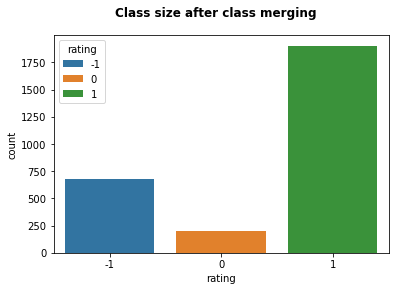

In [18]:
dataCleaned[ratingColName] = dataCleaned[ratingOrigColName] # Retrieve the original ratings before merging them
dataCleaned = dataCleaned.replace({ratingColName:[1,2]},-1).replace({ratingColName:[3]},0).replace({ratingColName:[4,5]},1)
    
classSize_plotter(dataCleaned, ratingColName, 'Class size after class merging')

In [33]:
TfidfVectorizerParams = {'sublinear_tf':True, 'strip_accents':None, 'lowercase':False, 'preprocessor':None} # To meke sure the same TfidfVectorizer params are used across the code
tfidf  = TfidfVectorizer(**TfidfVectorizerParams) # sublinear_tf=True
optClf, optClfName = optClf_finder(tfidf, clfNames, dataCleaned[reviewColName], dataCleaned[ratingColName])

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameter set: {'clf__n_neighbors': 9, 'clf__p': 2, 'clf__weights': 'uniform'}
CV Accuracy: 0.7163426925845933
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2'}
CV Accuracy: 0.7717782577393808
optimal clf is lr.


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .clf__n_neighbors=3, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END clf__n_neighbors=3, clf__p=1, clf__weights=distance; total time=   0.8s
[CV] END .clf__n_neighbors=5, clf__p=1, clf__weights=uniform; total time=   0.7s
[CV] END .clf__n_neighbors=5, clf__p=2, clf__weights=uniform; total time=   0.3s
[CV] END clf__n_neighbors=5, clf__p=2, clf__weights=distance; total time=   0.2s
[CV] END clf__n_neighbors=5, clf__p=2, clf__weights=distance; total time=   0.2s
[CV] END clf__n_neighbors=7, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END .clf__n_neighbors=7, clf__p=2, clf__weights=uniform; total time=   0.2s
[CV] END .clf__n_neighbors=7, clf__p=2, clf__weights=uniform; total time=   0.3s
[CV] END .clf__n_neighbors=9, clf__p=1, clf__weights=uniform; total time=   0.7s
[CV] END clf__n_neighbors=9, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END .......................clf__C=10.0, clf__penalty=l1; total time=   0.1s
[CV] END ...................

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END clf__n_neighbors=3, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END clf__n_neighbors=3, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END clf__n_neighbors=3, clf__p=2, clf__weights=distance; total time=   0.3s
[CV] END .clf__n_neighbors=5, clf__p=1, clf__weights=uniform; total time=   0.7s
[CV] END clf__n_neighbors=5, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END .clf__n_neighbors=7, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END clf__n_neighbors=7, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END clf__n_neighbors=7, clf__p=2, clf__weights=distance; total time=   0.2s
[CV] END .clf__n_neighbors=9, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END clf__n_neighbors=9, clf__p=1, clf__weights=distance; total time=   0.5s
[CV] END clf__n_neighbors=9, clf__p=2, clf__weights=distance; total time=   0.2s
[CV] END .......................clf__C=10.0, clf__penalty=l1; total time=   0.1s
[CV] END ...................

In [13]:
# data4.describe()

,rating
count,2778.000000
mean,0.442045
std,0.856497
min,-1.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


# Class (positive, neutral, negative) size

In [14]:
# print('3-class size: {}'.format(data4.shape[0])) 
# print('Positve class size: {}'.format(len(data4['rating'][data4.rating == 1 ])))
# print('Neutral class size: {}'.format(len(data4['rating'][data4.rating == 0 ])))
# print('Negative class size: {}'.format(len(data4['rating'][data4.rating == -1 ])))

3-class size: 2778

Positve class size: 1904

Neutral class size: 198

Negative class size: 676


# Word count per review

In [15]:
# def word_count(words):
#     return len(words.split())

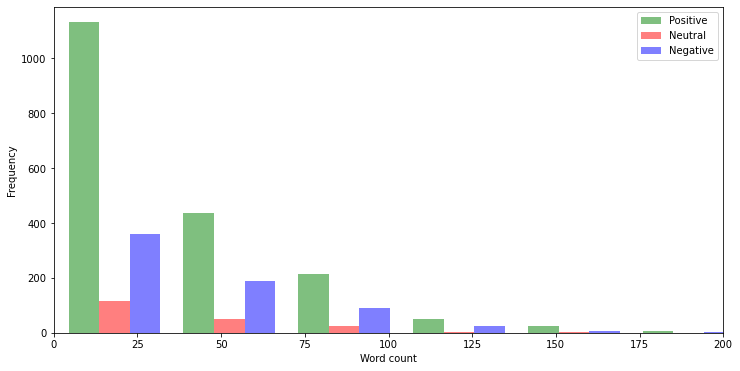

In [16]:
# data4['word count'] = data4['text'].apply(word_count)
# p = data4['word count'][data4.rating == 1]
# m = data4['word count'][data4.rating == 0]
# n = data4['word count'][data4.rating == -1]
# plt.figure(figsize=(12,6)) 
# plt.xlim(0,200)
# plt.xlabel('Word count')
# plt.ylabel('Frequency')
# g = plt.hist([p,m,n], color=['g','r','b'], alpha=0.5, label=['Positive','Neutral','Negative'])
# plt.legend(loc='upper right')

# Common words

In [33]:
# all_words = []
# for line in list(dataCleaned['text']):
#     words = line.split()
#     for word in words:
#       if (len(word)>2):
#         all_words.append(word.lower())
    
    
# Counter(all_words).most_common(20)
# mostCommonWords_finder(dataCleaned['text'], 20, 2)

[('good', 1130),
 ('use', 1070),
 ('veri', 838),
 ('like', 648),
 ('skin', 634),
 ('tea', 634),
 ('one', 568),
 ('soap', 472),
 ('amazon', 426),
 ('hair', 424),
 ('time', 420),
 ('buy', 384),
 ('tast', 378),
 ('watch', 342),
 ('also', 334),
 ('best', 330),
 ('qualiti', 328),
 ('smell', 316),
 ('look', 302),
 ('day', 300)]

# Data processing

In [18]:
# data4.columns 

Index(['asian', 'name', 'date', 'rating', 'text', 'word count'], dtype='object')

In [19]:
# data4.dtypes

asian         object
name          object
date          object
rating         int64
text          object
word count     int64
dtype: object

In [20]:
# data4

,asian,name,date,rating,text,word count
536,B01N8UHYTB,Titan-Analog-Black-Dial-Watch-NK1730SL02,2018-07-23,1,Perfect look. Bought for my friend. Color comb...,26
618,B08CN7SJBX,Maaza-1-2L,2020-07-08,-1,Received this bottle for which the expiry date...,20
234,B078X5298B,Godrej-No-1-Bathing-Soap-Lime,2019-10-18,1,We are using Godrej No1 soap from very long ti...,94
1299,B078KHP29L,Dettol-Disinfectant-Liquid-Menthol-Cool,2020-02-22,1,"Supply water in Delhi has foul smell, this liq...",37
1863,B00H5NMNXC,Himalaya-Moisturizing-Aloe-Vera-200ml,2018-07-30,0,Why free article not delivered/provided along ...,24
...,...,...,...,...,...,...
1495,B01MQNBOLA,Cinthol-Cool-Soap-100g-Free,2020-06-18,-1,"In television advertisement, the color of the ...",47
964,B01DKPA876,PATANJALI-Aloe-Pimples-Moisturizing-150ml,2020-03-24,1,It's is a perfect remedy of skin issues like r...,11
447,B012SPKP9U,Titan-Karishma-Analog-Blue-Watch-1774SM01,2019-08-14,1,Nice product,2
1587,B07NLLPYJ3,Britannia-Vita-Marie-Gold-150g,2019-11-04,1,Good,1


In [21]:
# data5 = data4.drop(['asian', 'name','date','word count'], axis=1, inplace=False) # Removing the unnecessary columns.

In [22]:
# data5.dtypes 

rating     int64
text      object
dtype: object

In [23]:
# data5.head(10)

,rating,text
536,1,Perfect look. Bought for my friend. Color comb...
618,-1,Received this bottle for which the expiry date...
234,1,We are using Godrej No1 soap from very long ti...
1299,1,"Supply water in Delhi has foul smell, this liq..."
1863,0,Why free article not delivered/provided along ...
1275,0,Dettol antiseptic liquid original is far bette...
287,1,I think one the best product I have used...It ...
1314,1,"In product detailed images,Soap cover is diffe..."
1083,1,I use this gel as my night cream and I am quit...
1236,1,Best but price is on mrp no discount


# Convrting review type from object to string

In [24]:
# data5['text'] = data5['text'].astype('str') # NOTICE: Not clear. What is the purpose?
# data5.dtypes

rating     int64
text      object
dtype: object

# Download 'stopwords', 'punkt', and 'wordnet' packages

In [25]:
# nltk.download('stopwords')
# stopword = set(stopwords.words('english'))
# nltk.download('punkt')
# nltk.download('wordnet')

[nltk_data] Downloading package stopwords to

[nltk_data]     C:\Users\fafdideh\AppData\Roaming\nltk_data...

[nltk_data]   Package stopwords is already up-to-date!

[nltk_data] Downloading package punkt to

[nltk_data]     C:\Users\fafdideh\AppData\Roaming\nltk_data...

[nltk_data]   Package punkt is already up-to-date!

[nltk_data] Downloading package wordnet to

[nltk_data]     C:\Users\fafdideh\AppData\Roaming\nltk_data...

[nltk_data]   Package wordnet is already up-to-date!


True

# Clean text: remove non-word, punctuations, stopwords, ...

In [26]:
# def cleanText(input_string):
#     modified_string = re.sub('[^A-Za-z0-9]+', ' ', input_string)
#     return(modified_string)

# def cleanText_v2(text): # SOURCE: Chapter 8 of the book: Python Machine Learning: Machine Learning and Deep Learning with Python
#     text = re.sub('<[^>]*>', '', text) # Removes all of the HTML markup from the reviews.
#     emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text) # Finds emoticons
#     text = (re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')) # Removes all non-word characters from the text via the regex [\W]+ and converts the text into lowercase characters.
#     return text

# data5['clean_review_text'] = data5.text.apply(cleanText)
# data5['clean_review_text'][150]

'I am writing this review after using it around 20 days It seems very natural and chemical free and is very gentle on skin But it does its job of cleaning the skin properly It contains tea tree which is one of my favourite ingredients for skin care Give it a try its definitely better than all other chemicals containing face washes And its even affordable as compared to other natural brands available in market '

In [27]:
# data5['clean_review_text']=data5['clean_review_text'].str.lower() # converting to lower case
# data5['clean_review_text']=data5['clean_review_text'].str.translate(str.maketrans('','',string.punctuation)) # removing punctuations

In [28]:
# stopWords=stopwords.words('english')+['the', 'a', 'an', 'i', 'he', 'she', 'they', 'to', 'of', 'it', 'from']
# def removeStopWords(stopWords, rvw_txt):
#     newtxt = ' '.join([word for word in rvw_txt.split() if word not in stopWords])
#     return newtxt
# data5['clean_review_text'] = [removeStopWords(stopWords,x) for x in data5['clean_review_text']]

# Tokeniza - lemmatize

In [29]:
# def process_tweets(tweet):    
#     tokens = word_tokenize(tweet) # tokenizing words    
#     final_tokens = [w for w in tokens if w not in stopword] # #Removing Stop Words. NOTICE: We had removed stopwords before in [184], so this line is extra
#     wordLemm = WordNetLemmatizer() # reducing a word to its word stem
#     finalwords = []
#     for w in final_tokens:
#       if len(w)>1:
#         try:
#             w = wordLemm.lemmatize(w)  
#         except:
#             pass
#         finalwords.append(w)
#     return ' '.join(finalwords)

# data5['final text'] = data5['clean_review_text'].apply(lambda x: process_tweets(x))
# data5.head(10)

,rating,text,clean_review_text,final text
536,1,Perfect look. Bought for my friend. Color comb...,perfect look bought friend color combination f...,perfect look bought friend color combination f...
618,-1,Received this bottle for which the expiry date...,received bottle expiry date already past way r...,received bottle expiry date already past way r...
234,1,We are using Godrej No1 soap from very long ti...,using godrej no1 soap long time fragrance soap...,using godrej no1 soap long time fragrance soap...
1299,1,"Supply water in Delhi has foul smell, this liq...",supply water delhi foul smell liquid certainly...,supply water delhi foul smell liquid certainly...
1863,0,Why free article not delivered/provided along ...,free article delivered provided along product ...,free article delivered provided along product ...
1275,0,Dettol antiseptic liquid original is far bette...,dettol antiseptic liquid original far better t...,dettol antiseptic liquid original far better t...
287,1,I think one the best product I have used...It ...,think one best product used freshens ur mood b...,think one best product used freshens ur mood b...
1314,1,"In product detailed images,Soap cover is diffe...",product detailed images soap cover different i...,product detailed images soap cover different i...
1083,1,I use this gel as my night cream and I am quit...,use gel night cream quite happy make beauty qu...,use gel night cream quite happy make beauty qu...
1236,1,Best but price is on mrp no discount,best price mrp discount,best price mrp discount


# Word cloud

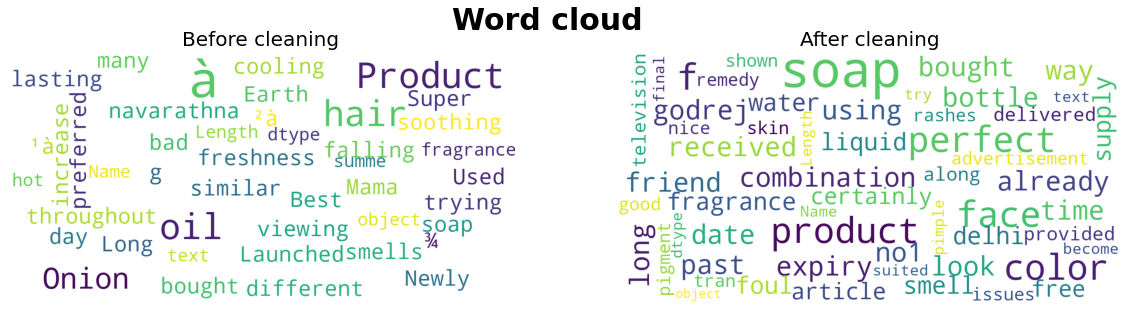

In [30]:
# def show_wordcloud(ax, data, title = None):
#     wordcloud = WordCloud(
#         background_color = 'white',
#         max_words = 200,
#         max_font_size = 40, 
#         scale = 3,
#         random_state = 42
#     ).generate(str(data))

#     ax.axis('off')
#     if title: 
#         ax.set_title(title, fontsize = 20)
#     ax.imshow(wordcloud)

# fig, axs = plt.subplots(1, 2, figsize = (20, 5)) 
# fig.suptitle('Word cloud', fontsize= 30, fontweight='bold')
# show_wordcloud(axs[0], data["text"], 'Before cleaning')
# show_wordcloud(axs[1], data5["final text"], 'After cleaning')
# plt.savefig("results/wordCloud.png")

# Imbalanced (skewed) class size

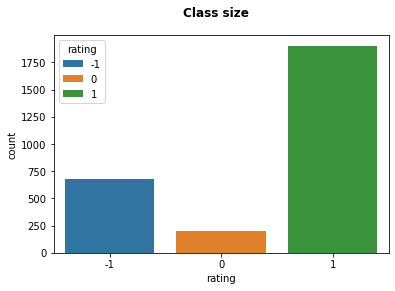

In [39]:
# %matplotlib inline
# sns.countplot(x='rating', hue='rating', data = data5, dodge=False)
# plt.suptitle('Class size', fontweight='bold')
# plt.savefig("results/classSize.png")

In [20]:
# # X = data5['final text'].values
# # Y = data5['rating'].values
Xtxt = dataCleaned[reviewColName].values
Ytxt = dataCleaned[ratingColName].values
# Xtxt = dataCleaned[reviewColName]
# Ytxt = dataCleaned[ratingColName]
# # Xtxt = X.copy()
# # Ytxt = Y.copy()
# print(Xtxt.shape)
# print(Ytxt.shape)

# Processing
* Evaluation strategy: N*K-fold Cross Validation (CV)
* Feature: TF-IDF vectorization
* Feature oversampling: Synthetic Minority Oversampling Technique (SMOTE)
* Classifiers: Naive Bayes (NB), Logistic Regression (LR), and Support Vector Machine (SVM, Linear)
* Validation metrics: 
 * One-vs-Rest (OvR) binary Receiver Operating Characteristic (ROC) curve + their macro-average across repetitions;
 * Area under the ROC Curve (AUC);
 * G-mean;
 * True Positive Rate (TPR), Positive Predictive Value (PPV), Accuracy (ACC);
 * One-vs-Rest (OvR) binary confusion matrix;
 * Multiclass (3) confusion matrix.

In [23]:
# classLabel = np.unique(Ytxt)
# classLabel[0]
# len(classLabel)
# list(np.unique(Ytxt))

[-1, 0, 1]

In [59]:
# optClf, optClfName
def split_feature_clf_cv(X, y, clf, n_splits, n_repeats, isBinary):
    """Splits into train/test; extracts features; trains & tests the classifier using N*K-fold cross-validation. Returns average test accuracy."""
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state) # 
    acc = []
    for train_index, test_index in cv.split(X, y): # 0<k<(n_repeats*n_splits-1)
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index] # train/test split
        tfidf = TfidfVectorizer(**TfidfVectorizerParams) # Feature extraction
        model = Pipeline([('tfidf', tfidf), ('clf', clf)]).fit(X_train, y_train)        
        acc.append(model.score(X_test, y_test)) # Classifier score        
        if isBinary:
            y_score = model.predict_proba(X_test)[:, 1]
            fpr, tpr, threshold = roc_curve(y_test, y_score) 
        else:
            fpr, tpr, threshold = np.nan, np.nan, np.nan
    return np.mean(acc), fpr, tpr, threshold

acc = split_feature_clf_cv(Xtxt, Ytxt, optClf, n_splits, n_repeats, 0)


In [48]:
clfIni == optClf #[0.9384449244060475, 0.9514038876889849, 0.927645788336933, 0.9395248380129589, 0.9395248380129589, 0.9449244060475162]

True

# ROC

In [35]:
# random_state = 1 # np.random.RandomState(0)
n_repeats = 10 #10: Number of repetitions of cross-validation
# n_splits = 4 #4

# classLabel = list(np.unique(Ytxt))
# n_classes = len(classLabel)

equalClassSize = 2000

def output_binariser(X, Y, classLabel):
    """Binarize the output"""
    y_binary = label_binarize(Y, classes=classLabel)

    X_binary = []
    Y_binary = []
    for i in range(y_binary.shape[1]): 
        Xrsmp, Yrsmp = X, y_binary[:, i]
        X_binary.append(Xrsmp)
        Y_binary.append(Yrsmp)
    return X_binary, Y_binary

X_binary, Y_binary = output_binariser(Xtxt, Ytxt, classLabel)
# model_svm = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
#                                  random_state=random_state)) # create model
# model_lr = OneVsRestClassifier(LogisticRegression(random_state=random_state)) # create model
# model_nb = OneVsRestClassifier(BernoulliNB()) # create model
# optClf, optClfName
model_nb = OneVsRestClassifier(optClf)

models = {'Naive Bayes (NB)' : model_nb} #  , 'Logistic Regression (LR)' : model_lr, 'Support vector Machine (SVM)' : model_svm
models_name_abbrv = ['NB', 'LR', 'SVM']
colors_models = ['r', 'g', 'b'] 

colors_classes = ['r', 'g', 'b']
colors_classes_CF = ['Reds', 'Greens', 'Blues'] 

n_models = len(models)


def idx_finder_micro(classNb):
    idx = []
    for i in range(n_repeats*n_splits):
        idx.append(np.asarray(list(range((classNb-1)*X_test.shape[0], classNb*X_test.shape[0]))) + i * (n_classes-1)*X_test.shape[0])
    idx = np.hstack(idx)
    return idx


def fpr_unique_finder(classNb, fpr_all):
    idx = list(range((classNb-1), n_classes * n_repeats*n_splits, n_classes))
    fprSel = []
    for i in idx:
        fprSel.append(fpr_all[i])
    fprUnique = np.unique(np.concatenate(np.asarray(fprSel)))
    return fprUnique


def microAvg_calc(n_classes, y_test_all_ravel, y_score_all):
    # Compute micro-average ROC curve and ROC area
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        micro_tmp = "micro_{}".format(i+1)
        fpr[micro_tmp], tpr[micro_tmp], _ = roc_curve(y_test_all_ravel[idx_finder_micro(i+1)], y_score_all[idx_finder_micro(i+1)])
        roc_auc[micro_tmp] = auc(fpr[micro_tmp], tpr[micro_tmp])  
    
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_all_ravel, y_score_all)
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc


def roc_bestThr(tpr, fpr, thr, fieldName):
#     https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
    roc_auc = {}
    gmeans = np.sqrt(tpr * (1-fpr)) # calculate the g-mean for each threshold
    roc_auc["{}BestThrIdx".format(fieldName)] = np.argmax(gmeans) # locate the index of the largest g-mean
    roc_auc["{}BestThrVal".format(fieldName)] = thr[roc_auc["{}BestThrIdx".format(fieldName)]] 
    roc_auc["{}BestThrGmeans".format(fieldName)] = gmeans[roc_auc["{}BestThrIdx".format(fieldName)]]
    return roc_auc


def macroAvg_calc(n_classes, n_repeats, n_splits, fpr_all, fpr, tpr, thresholds):
    # First aggregate all false positive rates
    fpr_unique_perClass = []
    for i in range(n_classes):
        fpr_unique_perClass.append(fpr_unique_finder(i+1, fpr_all))  

    fpr_unique = np.unique(np.concatenate(fpr_all))

    # Then interpolate all ROC curves at this points
    mean_tpr_perClass = {0: np.zeros_like(fpr_unique_perClass[0]), 1: np.zeros_like(fpr_unique_perClass[1]), 2: np.zeros_like(fpr_unique_perClass[2])}
    mean_tpr = np.zeros_like(fpr_unique)
    mean_thr_perClass = {0: np.zeros_like(fpr_unique_perClass[0]), 1: np.zeros_like(fpr_unique_perClass[1]), 2: np.zeros_like(fpr_unique_perClass[2])}
    mean_thr = np.zeros_like(fpr_unique)
    for i in range(n_classes):
        for j in range(n_repeats*n_splits):
            mean_tpr += interp(fpr_unique, fpr[i][j], tpr[i][j])
            mean_tpr_perClass[i] += interp(fpr_unique_perClass[i], fpr[i][j], tpr[i][j])
            mean_thr += interp(fpr_unique, fpr[i][j], thresholds[i][j])
            mean_thr_perClass[i] += interp(fpr_unique_perClass[i], fpr[i][j], thresholds[i][j])
    # Finally average it and compute AUC
    mean_tpr /= (n_classes * n_repeats*n_splits)
    mean_thr /= (n_classes * n_repeats*n_splits)
    for i in range(n_classes):
        mean_tpr_perClass[i] /= (n_repeats*n_splits)
        mean_thr_perClass[i] /= (n_repeats*n_splits)

    roc_auc = dict()
    for i in range(n_classes):
        macro_tmp = "macro_{}".format(i+1)                         
        fpr[macro_tmp], tpr[macro_tmp] = np.hstack([0, fpr_unique_perClass[i], 1]), np.hstack([0, mean_tpr_perClass[i], 1])
        
        roc_auc_ = roc_bestThr(tpr[macro_tmp], fpr[macro_tmp], mean_thr_perClass[i], macro_tmp)
        roc_auc.update(roc_auc_)
    
        roc_auc[macro_tmp] = auc(fpr[macro_tmp], tpr[macro_tmp])

    fpr["macro"], tpr["macro"] = np.hstack([0, fpr_unique, 1]), np.hstack([0, mean_tpr, 1])
    roc_auc_ = roc_bestThr(tpr["macro"], fpr["macro"], mean_thr, "macro")
    roc_auc.update(roc_auc_)
    
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])                                 
    return fpr, tpr, roc_auc                             


def model_fit_cv(X, y_binary, classifier):
    rowNb = equalClassSize * 2
    
    classifierIni = classifier
    y_score_svm = np.array([np.ones((rowNb, len(y_binary)))*10] * n_splits * n_repeats)  #list() # []
    y_test_all = np.array([np.ones((rowNb, len(y_binary)))*10] * n_splits * n_repeats)
    
    for i in range(len(y_binary)): 
        cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state) # 
        for k, (train_index, test_index) in enumerate(cv.split(X[i], y_binary[i])):
            X_train, X_test = X[i][train_index], X[i][test_index]
            y_train, y_test = y_binary[i][train_index], y_binary[i][test_index]  
    
            vector = TfidfVectorizer(sublinear_tf=True)
            X_train = vector.fit_transform(X_train)
            X_test = vector.transform(X_test)
    
#             smote = SMOTE(random_state=random_state, sampling_strategy={0:equalClassSize, 1:equalClassSize}) # 
#             X_train, y_train = smote.fit_resample(X_train, y_train)

#             smote = SMOTE(random_state=random_state, sampling_strategy={0:equalClassSize, 1:equalClassSize})
#             X_test, y_test = smote.fit_resample(X_test, y_test)
    
            classifier = classifierIni
            y_score = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1] # decision_function

            y_score_svm[k][:, i] = y_score
            y_test_all[k][:, i] = y_test
   
    return y_score_svm, y_test_all#, test_indexAll


def fpr_tpr_roc_auc_initialiser():
# Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresholds = dict()

    for i in range(n_classes):
        fpr[i] = []
        tpr[i] = []
        roc_auc[i] = []
        thresholds[i] = []
    return  fpr, tpr, roc_auc, thresholds                            


def fpr_tpr_roc_auc_calc(n_classes, fpr, tpr, roc_auc, thresholds, y_score_svm, y_test_all):
    y_score_all = []
    y_test_all_ravel = []
    fpr_all = []
    for y_score, y_test in zip(y_score_svm, y_test_all):
        y_score_all.append(y_score.ravel())
        y_test_all_ravel.append(y_test.ravel())
        
        for i in range(n_classes):
            fpr_, tpr_, thresholds_ = roc_curve(y_test[:, i], y_score[:, i])
            fpr_all.append(fpr_)
            fpr[i].append(fpr_)
            tpr[i].append(tpr_)
            auc_ = auc(fpr_, tpr_)
            roc_auc[i].append(auc_)
            thresholds[i].append(thresholds_)

    y_score_all = np.hstack(y_score_all)
    y_test_all_ravel = np.hstack(y_test_all_ravel)
    return fpr_all, fpr, tpr, roc_auc, thresholds, y_score_all, y_test_all_ravel

In [ ]:
fig, ax = plt.subplots(n_models+1, n_classes+1, figsize=(16,4*(n_models+1)), sharey=True, sharex=True)
fig.suptitle('Multi-class ROC averaged on {}*{}-fold Cross-validation performance evaluation technique'.format(n_repeats, n_splits), 
            fontsize=20, fontweight='bold')  
lw = 2
    
fpr_models = dict()
tpr_models = dict()  

for k, (model_name, classifier) in enumerate(models.items()):
 
    y_score_svm, y_test_all= model_fit_cv(X_binary, Y_binary, classifier) 

# Visualisation

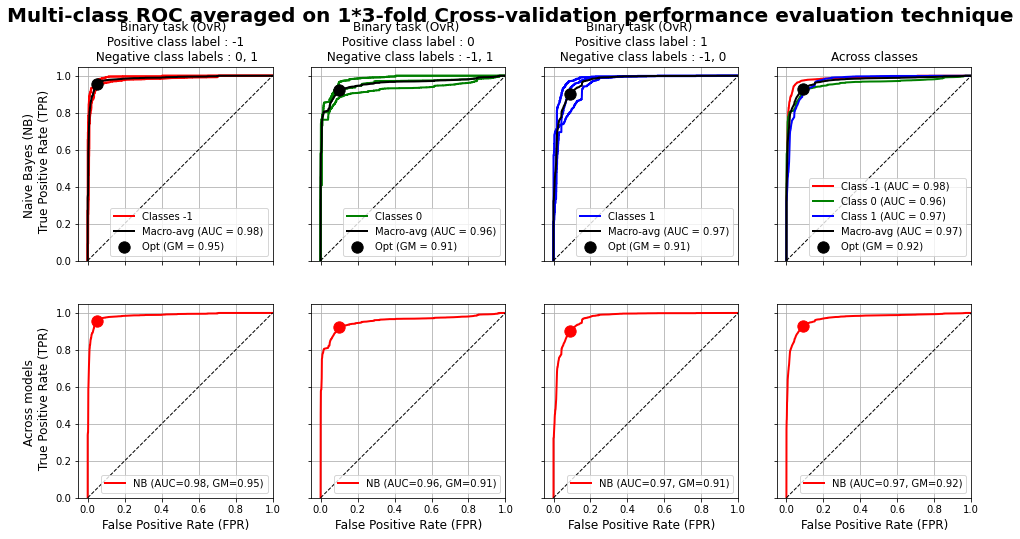

In [27]:
fig, ax = plt.subplots(n_models+1, n_classes+1, figsize=(16,4*(n_models+1)), sharey=True, sharex=True)
fig.suptitle('Multi-class ROC averaged on {}*{}-fold Cross-validation performance evaluation technique'.format(n_repeats, n_splits), 
            fontsize=20, fontweight='bold')  
lw = 2
    
fpr_models = dict()
tpr_models = dict()  

for k, (model_name, classifier) in enumerate(models.items()):
 
    y_score_svm, y_test_all= model_fit_cv(X_binary, Y_binary, classifier) 
    
    fpr, tpr, roc_auc, thresholds = fpr_tpr_roc_auc_initialiser()    

    fpr_all, fpr, tpr, roc_auc, thresholds, y_score_all, y_test_all_ravel = fpr_tpr_roc_auc_calc(n_classes, fpr, tpr, roc_auc, thresholds, y_score_svm, y_test_all)

    fpr_macro, tpr_macro, roc_auc_macro = macroAvg_calc(n_classes, n_repeats, n_splits, fpr_all, fpr, tpr, thresholds)                            
    fpr.update(fpr_macro)
    tpr.update(tpr_macro)
    roc_auc.update(roc_auc_macro)
                                 
    # Plot all ROC curves  
    for i in range(n_classes):
        for j in range(n_repeats*n_splits):
            if j == 1:
                ax[k, i].plot(fpr[i][j], tpr[i][j], color=colors_classes[i], lw=lw, label='Classes {}'.format(classLabel[i]), alpha=1) # 
            ax[k, i].plot(fpr[i][j], tpr[i][j], color=colors_classes[i], lw=lw) # , alpha=0.5

        ax[k, i].plot(fpr["macro_{}".format(i+1)], tpr["macro_{}".format(i+1)], 'k', lw=lw, label='Macro-avg (AUC = {0:0.2f})'
                     .format(roc_auc["macro_{}".format(i+1)]))
        ax[k, i].scatter(fpr["macro_{}".format(i+1)][roc_auc["macro_{}BestThrIdx".format(i+1)]], 
                         tpr["macro_{}".format(i+1)][roc_auc["macro_{}BestThrIdx".format(i+1)]], 
                         marker='o', color='k', s=2**7, zorder=20,
                        label='Opt (GM = {0:0.2f})'.format(roc_auc["macro_{}BestThrGmeans".format(i+1)]))
        ax[k, i].axis('square')
        ax[k, i].plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
        ax[k, i].axis([-0.05, 1.0, 0.0, 1.05])
        if i == 0:
            ax[k, i].set_ylabel('{} \n True Positive Rate (TPR)'.format(model_name), fontsize=12)
        if k == 0:
            theRest = classLabel.copy()
            theRest.pop(i)
            ax[k, i].set_title ("Binary task (OvR) \n Positive class label : {} \n Negative class labels : {}, {}".format(classLabel[i], theRest[0], theRest[1]), 
                                fontdict = {'size':12}) # , pad = 20    
        ax[k, i].legend(loc="lower right")
        ax[k, i].grid()
    
    for i in range(n_classes):
        ax[k, n_classes].plot(fpr["macro_{}".format(i+1)], tpr["macro_{}".format(i+1)], colors_classes[i], lw=lw, 
                   label='Class {0} (AUC = {1:0.2f})'
                     .format(classLabel[i], roc_auc["macro_{}".format(i+1)]))        
    ax[k, n_classes].plot(fpr["macro"], tpr["macro"], 'k', lw=lw, label='Macro-avg (AUC = {0:0.2f})'
                     .format(roc_auc["macro"]))
    ax[k, n_classes].scatter(fpr["macro"][roc_auc["macroBestThrIdx"]], 
                         tpr["macro"][roc_auc["macroBestThrIdx"]], 
                         marker='o', color='k', s=2**7, zorder=20,
                            label='Opt (GM = {0:0.2f})'.format(roc_auc["macroBestThrGmeans"]))
    ax[k, n_classes].axis('square')
    ax[k, n_classes].plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
    ax[k, n_classes].axis([-0.05, 1.0, 0.0, 1.05])
    if k == len(models):
        ax[k, n_classes].set_xlabel('False Positive Rate (FPR)', fontsize=12)
    if k == 0:
        ax[k, n_classes].set_title('Across classes', fontsize=12)
    ax[k, n_classes].legend(loc="lower right")
    ax[k, n_classes].grid()

    fpr_models[model_name] = (fpr, tpr, roc_auc)


for i in range(n_classes):
    for j, model_name in enumerate(models.keys()):
        ax[n_models, i].plot(fpr_models[model_name][0]["macro_{}".format(i+1)], 
                             fpr_models[model_name][1]["macro_{}".format(i+1)], 
                      color=colors_models[j], lw=lw, label='{0} (AUC={1:0.2f}, GM={2:0.2f})'
                     .format(models_name_abbrv[j], fpr_models[model_name][2]["macro_{}".format(i+1)], fpr_models[model_name][2]["macro_{}BestThrGmeans".format(i+1)]))
        ax[n_models, i].scatter(fpr_models[model_name][0]["macro_{}".format(i+1)][fpr_models[model_name][2]["macro_{}BestThrIdx".format(i+1)]], 
                         fpr_models[model_name][1]["macro_{}".format(i+1)][fpr_models[model_name][2]["macro_{}BestThrIdx".format(i+1)]], 
                         marker='o', color=colors_models[j], s=2**7, zorder=20), #label='Best {}'.format(models_name_abbrv[j])

    ax[n_models, i].axis('square')
    ax[n_models, i].plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
    ax[n_models, i].axis([-0.05, 1.0, 0.0, 1.05])  
    ax[n_models, i].set_xlabel('False Positive Rate (FPR)', fontsize=12)
    if i == 0:
        ax[n_models, i].set_ylabel('Across models \n True Positive Rate (TPR)', fontsize=12)
    ax[n_models, i].legend(loc="lower right")   
    ax[n_models, i].grid()
    
for i, model_name in enumerate(models.keys()):
    ax[n_models, n_classes].plot(fpr_models[model_name][0]["macro"], fpr_models[model_name][1]["macro"], color=colors_models[i], 
                  lw=lw, label='{0} (AUC={1:0.2f}, GM={2:0.2f})'
                     .format(models_name_abbrv[i], fpr_models[model_name][2]["macro"], fpr_models[model_name][2]["macroBestThrGmeans"]))
    ax[n_models, n_classes].scatter(fpr_models[model_name][0]["macro"][fpr_models[model_name][2]["macroBestThrIdx"]], 
                                    fpr_models[model_name][1]["macro"][fpr_models[model_name][2]["macroBestThrIdx"]], 
                         marker='o', color=colors_models[i], s=2**7, zorder=20) #, #label='Best {}'.format(models_name_abbrv[i])

ax[n_models, n_classes].axis('square')
ax[n_models, n_classes].plot([0, 1], [0, 1], 'k--', lw=0.5*lw)
ax[n_models, n_classes].axis([-0.05, 1.0, 0.0, 1.05])
ax[n_models, n_classes].set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax[n_models, n_classes].legend(loc="lower right") 
ax[n_models, n_classes].grid()
plt.savefig("../working/ROC.png")

# Confusion matrix

In [28]:
test_size = 0.25


def plot_confusion_matrix(ax, cf_matrix, cf_dim):
# Compute and plot the Confusion matrix
    
    if cf_dim == 2:
        categories  = ['Negative', "Positive"]
        group_names = ['TN','FP',"FN", 'TP']
    elif cf_dim == 3:
        categories  = ['Negative',"Neutral",'Positive']
        group_names = ['Correct','Wrong',"Wrong", 'Wrong','Correct',"Wrong",'Wrong','Wrong',"Correct"]
    
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.ravel() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(cf_dim, cf_dim)

    if cf_dim == 2:
        cmap = colors_classes_CF[i]
    elif cf_dim == n_classes:
        cmap = 'Greys'
    h = sns.heatmap(cf_matrix, ax=ax, annot = labels, cmap = cmap,fmt = '',
                xticklabels = categories, yticklabels = categories)
    ax.set_ylim(cf_dim, 0)
    ax.set_yticklabels(labels=ax.get_yticklabels(), va='center')
    
    if cf_dim == 2:
        tn, fp, fn, tp = cf_matrix.ravel()
        tpr = tp / (tp + fn)
        ppv = tp / (tp + fp)    
        acc = (tp + tn) / (tp + tn + fn + fp)
    elif cf_dim == n_classes:
        acc = np.sum(np.diag(cf_matrix)) / np.sum(cf_matrix)
        tpr = np.nan
        ppv = np.nan 
    return (tpr, ppv, acc)


def model_fit_total(ax, X_train, X_test, y_train, y_test, classifier, threshold, cf_dim):
    if cf_dim == 2:
        y_score = classifier.fit(X_train, y_train).predict_proba(X_test)[:, 1] # decision_function
        y_score[y_score >= threshold] = 1
        y_score[y_score < threshold] = 0
    elif cf_dim == 3:
        y_score = classifier.fit(X_train, y_train).predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_score)
    tpr, ppv, acc = plot_confusion_matrix(ax, cf_matrix, cf_dim) 
    return (tpr, ppv, acc)

# Visualisation

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

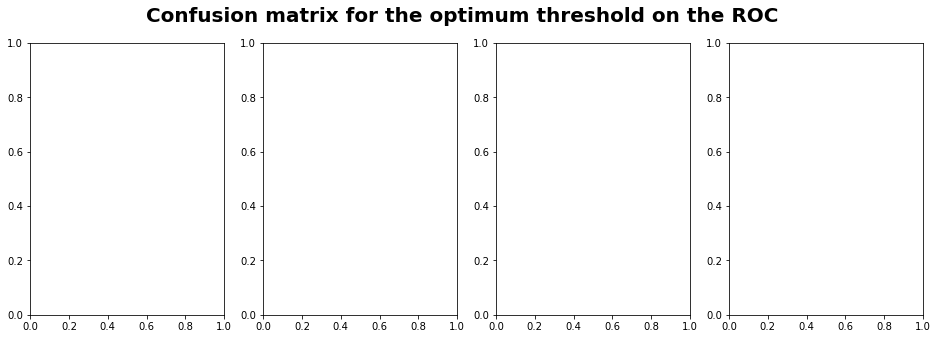

[CV] END clf__n_neighbors=3, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END clf__n_neighbors=3, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END .clf__n_neighbors=5, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END clf__n_neighbors=5, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END clf__n_neighbors=5, clf__p=2, clf__weights=distance; total time=   0.2s
[CV] END clf__n_neighbors=7, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END .clf__n_neighbors=7, clf__p=2, clf__weights=uniform; total time=   0.2s
[CV] END .clf__n_neighbors=7, clf__p=2, clf__weights=uniform; total time=   0.2s
[CV] END .clf__n_neighbors=9, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END clf__n_neighbors=9, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END clf__n_neighbors=9, clf__p=2, clf__weights=distance; total time=   0.3s
[CV] END .......................clf__C=10.0, clf__penalty=l1; total time=   0.1s
[CV] END ...................

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


[CV] END .clf__n_neighbors=3, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END .clf__n_neighbors=3, clf__p=2, clf__weights=uniform; total time=   0.3s
[CV] END .clf__n_neighbors=3, clf__p=2, clf__weights=uniform; total time=   0.2s
[CV] END clf__n_neighbors=3, clf__p=2, clf__weights=distance; total time=   0.2s
[CV] END clf__n_neighbors=5, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END .clf__n_neighbors=5, clf__p=2, clf__weights=uniform; total time=   0.2s
[CV] END .clf__n_neighbors=5, clf__p=2, clf__weights=uniform; total time=   0.2s
[CV] END .clf__n_neighbors=7, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END clf__n_neighbors=7, clf__p=1, clf__weights=distance; total time=   0.6s
[CV] END clf__n_neighbors=7, clf__p=2, clf__weights=distance; total time=   0.2s
[CV] END .clf__n_neighbors=9, clf__p=1, clf__weights=uniform; total time=   0.6s
[CV] END .clf__n_neighbors=9, clf__p=2, clf__weights=uniform; total time=   0.3s
[CV] END .clf__n_neighbors=9

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [29]:
fig, ax = plt.subplots(n_models, n_classes+1, figsize=(16,5*(n_models))) # , sharey=True, sharex=True
fig.suptitle('Confusion matrix for the optimum threshold on the ROC', fontsize=20, fontweight='bold') 
# X_trainOrig, X_testOrig, y_train, y_test = train_test_split(XSmote, YSmote, test_size = test_size, random_state=random_state)
X_trainOrig, X_testOrig, y_train, y_test = train_test_split(Xtxt, Ytxt, test_size = test_size, random_state=random_state)
vector = TfidfVectorizer(sublinear_tf=True)
X_trainOrig = vector.fit_transform(X_trainOrig)
X_testOrig = vector.transform(X_testOrig)

smote = SMOTE(random_state=random_state, sampling_strategy={-1:equalClassSize, 0:equalClassSize, 1:equalClassSize}) # 
X_trainOrig, y_train = smote.fit_resample(X_trainOrig, y_train)
X_testOrig, y_test = smote.fit_resample(X_testOrig, y_test)
    
for i in range(n_classes):
    X_train, X_test, y_binary_train, y_binary_test = train_test_split(X_binary[i], Y_binary[i], test_size=test_size, random_state=random_state)
    
    vector = TfidfVectorizer(sublinear_tf=True)
    X_train = vector.fit_transform(X_train)
    X_test = vector.transform(X_test)

    smote = SMOTE(random_state=random_state, sampling_strategy={0:equalClassSize, 1:equalClassSize}) # 
    X_train, y_binary_train = smote.fit_resample(X_train, y_binary_train)
    X_test, y_binary_test = smote.fit_resample(X_test, y_binary_test)
            
    for k, (model_name, classifier) in enumerate(models.items()):
        threshold = fpr_models[model_name][2]["macro_{}BestThrVal".format(i+1)]
        cf_dim = 2
        
#         tpr, ppv, acc = model_fit_total(ax[k, i], X_train, X_test, y_binary_train[:, i], y_binary_test[:, i], classifier, threshold, cf_dim)
        tpr, ppv, acc = model_fit_total(ax[k, i], X_train, X_test, y_binary_train, y_binary_test, classifier, threshold, cf_dim)
        
        if k == n_models - 1:
            ax[k, i].set_xlabel("Predicted values", fontdict = {'size':12}) #, labelpad = 10
        if i == 0:
            ax[k, i].set_ylabel("{} \n Actual values".format(model_name), fontdict = {'size':12}) # , labelpad = 10       
        if k == 0:    
            theRest = classLabel.copy()
            theRest.pop(i)
            ax[k, i].set_title ("Binary task (OvR)\nPositive class label : {0:d}\nNegative class labels : {1:d}, {2:d}\nTPR={3:.2%}, PPV={4:.2%} \n ACC={5:.2%}".format(classLabel[i], theRest[0], theRest[1],tpr, ppv, acc), 
                                fontdict = {'size':12}) # , pad = 20
        else:
            ax[k, i].set_title ("TPR={0:.2%}, PPV={1:.2%} \n ACC={2:.2%}".format(tpr, ppv, acc), 
                                fontdict = {'size':12}) # , pad = 20
            
       
for k, (model_name, classifier) in enumerate(models.items()):              
    threshold = fpr_models[model_name][2]["macroBestThrVal"]
    cf_dim = 3

    tpr, ppv, acc = model_fit_total(ax[k, n_classes], X_trainOrig, X_testOrig, y_train, y_test, classifier, [], cf_dim)

    if k == n_models - 1:
        ax[k, n_classes].set_xlabel("Predicted values", fontdict = {'size':12}) #, labelpad = 10
    if k == 0:
        ax[k, n_classes].set_title ("Multi-class task\nAcc={0:.2%}".format(acc), fontdict = {'size':12}) # , pad = 20
    else:
        ax[k, n_classes].set_title ("Acc={0:.2%}".format(acc), fontdict = {'size':12})
plt.savefig("../working/confusion.png")